# GUC Clustering Project 

**Objective:** 
The objective of this project teach students how to apply clustering to real data sets

The projects aims to teach student: 
* Which clustering approach to use
* Compare between Kmeans, Hierarchal, DBScan, and Gaussian Mixtures  
* How to tune the parameters of each data approach
* What is the effect of different distance functions (optional) 
* How to evaluate clustering approachs 
* How to display the output
* What is the effect of normalizing the data 

Students in this project will use ready-made functions from Sklearn, plotnine, numpy and pandas 
 



In [1]:
# if plotnine is not installed in Jupter then use the following command to install it 
#!pip install plotnine

Running this project require the following imports 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
from sklearn.datasets import make_blobs
from plotnine import *   
# StandardScaler is a function to normalize the data 
# You may also check MinMaxScaler and MaxAbsScaler 
#from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

%matplotlib inline

In [3]:
linkage_list=["average","single"]
affinity_list=["euclidean","manhattan","cosine"]

In [4]:
#function to plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [5]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'  #List colors
    alpha = 0.5  #color obaque
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [6]:
#function to plot results for each K
def res_k(data,start,end):
    list_num_clusters = list(range(start,end))
    for num_clusters in list_num_clusters:
        km = KMeans(n_clusters=num_clusters)
        c= km.fit(data)
        u_labels = np.unique(km.labels_)
        for i in u_labels:
            plt.scatter(data[km.labels_ == i , 0] , data[km.labels_ == i , 1] , label = i)
        plt.legend()
        plt.show()

In [7]:
#function for elbow method
def elbow(data,start,end):
    inertia = []
    list_num_clusters = list(range(start,end))
    for num_clusters in list_num_clusters:
        km = KMeans(n_clusters=num_clusters)
        c= km.fit(data)
        inertia.append(km.inertia_)
    plt.plot(list_num_clusters,inertia)
    plt.scatter(list_num_clusters,inertia)
    plt.xlabel('K')
    plt.ylabel('Inertia');


In [8]:
#function to plot silhouette score vs k
def silhouette_vs_k(data,start,end):
    silhouette_scores = []
    list_num_clusters = list(range(start,end))
    for num_clusters in list_num_clusters:
        km = KMeans(n_clusters=num_clusters)
        c= km.fit(data)
        silhouette_scores.append(silhouette_score(data,km.labels_,metric='euclidean'))
    
    plt.plot(list_num_clusters,silhouette_scores)
    plt.scatter(list_num_clusters,silhouette_scores)
    plt.xlabel('K')
    plt.ylabel('Silhouette Score');
    k_means_silhouette=max(silhouette_scores)
    K=silhouette_scores.index(k_means_silhouette)+2 # best K
    print("The best silhouette score is "+str(k_means_silhouette)+" for "+str(K)+" clusters.")

In [9]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

In [10]:
#contour for gmm
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo','blue','yellow','orange','pink']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()


In [11]:
def plot_contour():
    X, Y = np.meshgrid(np.linspace(-1, 6), np.linspace(-1,6))
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = gmm.score_samples(XX)
    Z = Z.reshape((50,50))
    plt.contour(X, Y, Z)
    plt.scatter(Multi_blob_Data[:, 0], Multi_blob_Data[:,1])
    plt.show()

In [12]:
def plot_agg_2d(data):
    list_num_clusters = list(range(2,10))
    u_labels = np.unique(model.labels_)
    for i in u_labels:
        plt.scatter(data[model.labels_ == i , 0] , data[model.labels_ == i , 1] , label = i)
    plt.legend()
    plt.show()
    silhouette=silhouette_score(data,model.labels_,metric='euclidean')
    return silhouette

In [13]:
def dendrogram_all(data):
    linkage_list=["average","single"]
    affinity_list=["euclidean","manhattan","cosine"]
    for affinity in affinity_list:
           for linkage in linkage_list:
                model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity=affinity, linkage=linkage)
                model = model.fit(data)
                plt.title('Dendrogram affinity= '+str(affinity)+" & linkage= "+str(linkage)+".")
                plot_dendrogram(model, truncate_mode='level', p=3)
                plt.xlabel("Number of points in node (or index of point if no parenthesis).")
                plt.ylabel("Distance between clusters")
                plt.show()

In [14]:
def show_cluster_agg_2d(data,n):
    s=[]
    linkage_list=["average","single"]
    affinity_list=["euclidean","manhattan","cosine"]
    for affinity in affinity_list:
           for linkage in linkage_list:
                model = AgglomerativeClustering(n_clusters=n, affinity=affinity, linkage=linkage)
                model = model.fit(data)
                silhouette=silhouette_score(data,model.labels_,metric='euclidean')
                s.append(silhouette)
                print("Silhouette Score for "+str(affinity)+" and "+str(linkage)+" is "+str(silhouette))
                list_num_clusters = list(range(2,10))
                u_labels = np.unique(model.labels_)
                for i in u_labels:
                #plt.title(str(affinty)+" "+str(linkage))
                    plt.scatter(data[model.labels_ == i , 0] , data[model.labels_ == i , 1] , label = i)
                plt.legend()
                plt.show()

## Multi Blob Data Set 
* The Data Set generated below has 6 cluster with varying number of users and varing densities
* Cluster the data set below using 



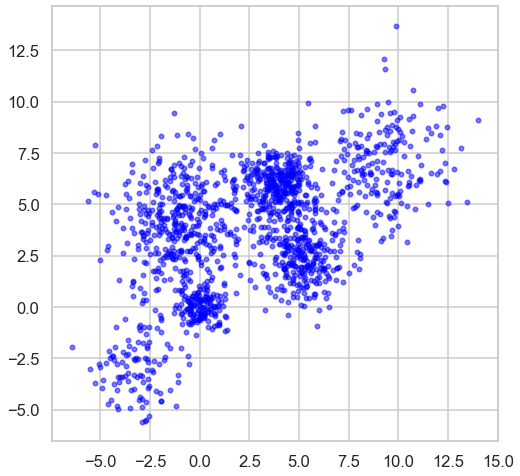

In [15]:
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
sns.set_context("talk")

n_bins = 6  
centers = [(-3, -3), (0, 0), (5,2.5),(-1, 4), (4, 6), (9,7)]
Multi_blob_Data, y = make_blobs(n_samples=[100,150, 300, 400,300, 200], n_features=2, cluster_std=[1.3,0.6, 1.2, 1.7,0.9,1.7],
                  centers=centers, shuffle=False, random_state=42)
display_cluster(Multi_blob_Data)

### Kmeans 
* Use Kmeans with different values of K to cluster the above data 
* Display the outcome of each value of K 
* Plot distortion function versus K and choose the approriate value of k 
* Plot the silhouette_score versus K and use it to choose the best K 
* Store the silhouette_score for the best K for later comparison with other clustering techniques. 

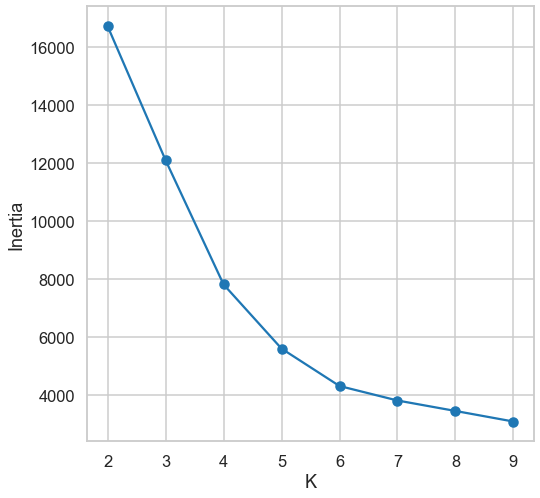

In [16]:
#Elbow Method
elbow(Multi_blob_Data,2,10)

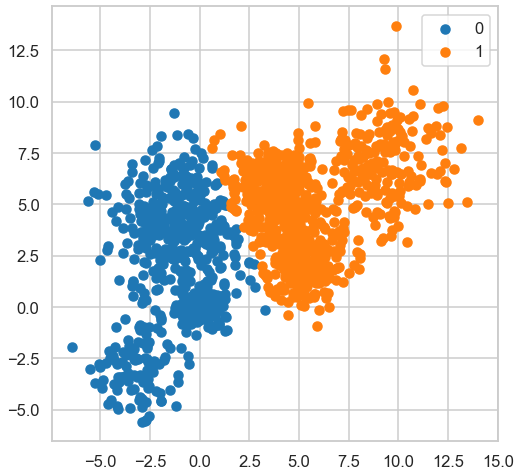

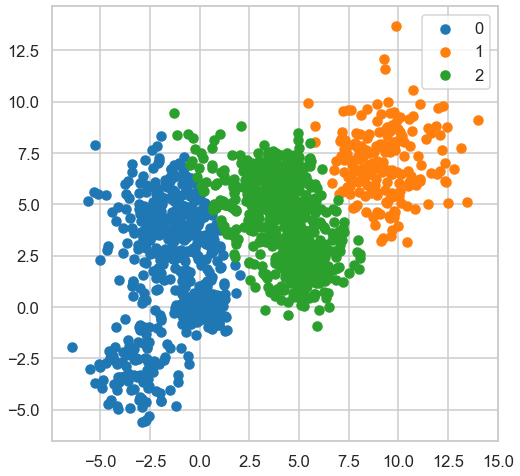

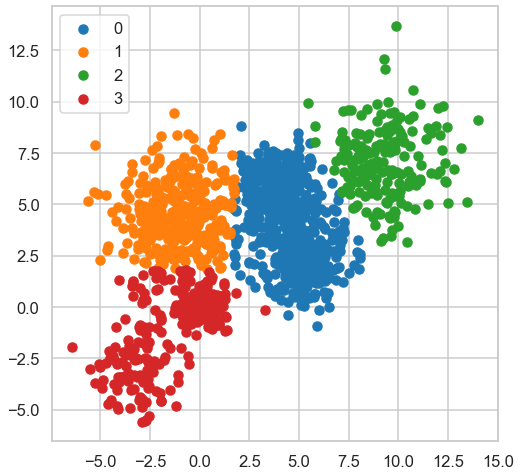

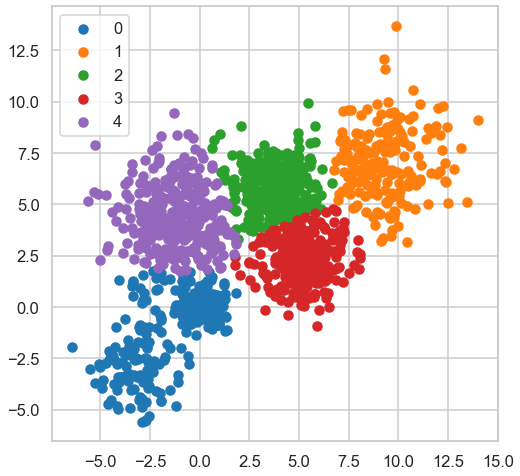

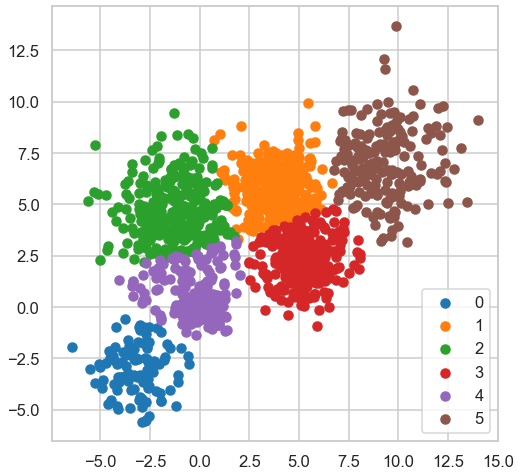

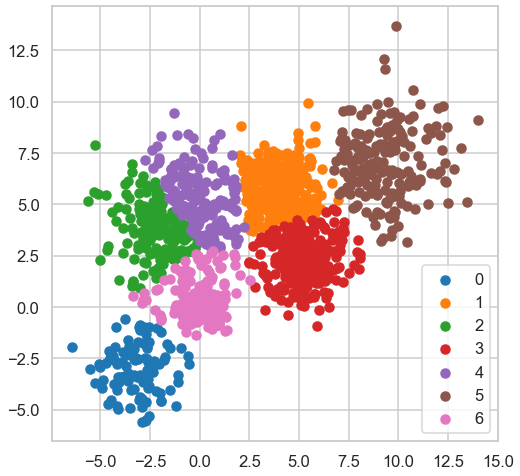

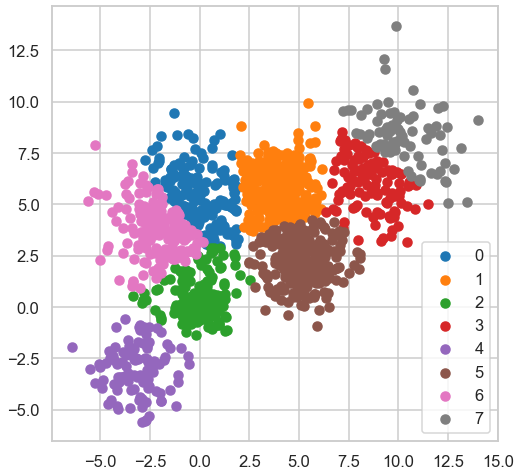

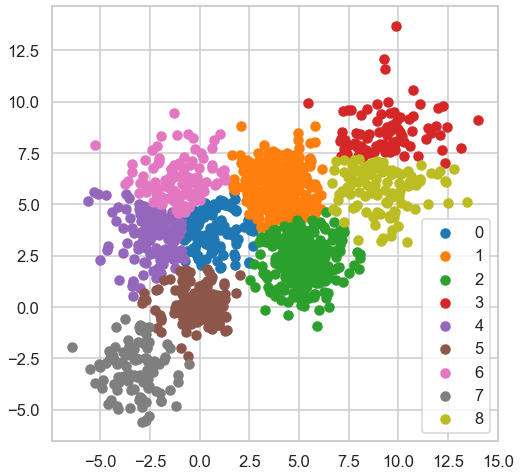

In [17]:
 res_k(Multi_blob_Data,2,10)

The best silhouette score is 0.48609408962389006 for 6 clusters.


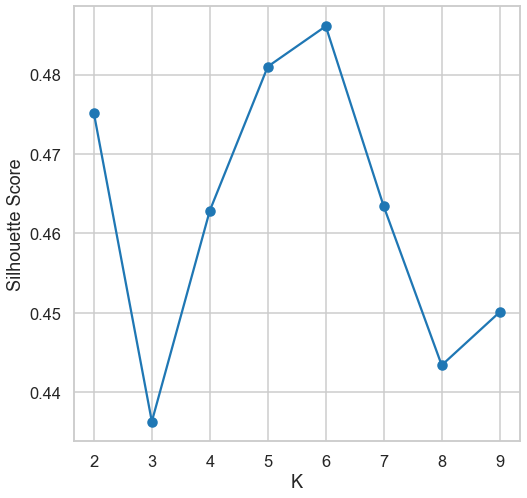

In [18]:
silhouette_vs_k(Multi_blob_Data,2,10)

### Hierarchal Clustering
* Use AgglomerativeClustering function to  to cluster the above data 
* In the  AgglomerativeClustering change the following parameters 
    * Affinity (use euclidean, manhattan and cosine)
    * Linkage( use average and single )
    * Distance_threshold (try different)
* For each of these trials plot the Dendograph , calculate the silhouette_score and display the resulting clusters  
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observation 

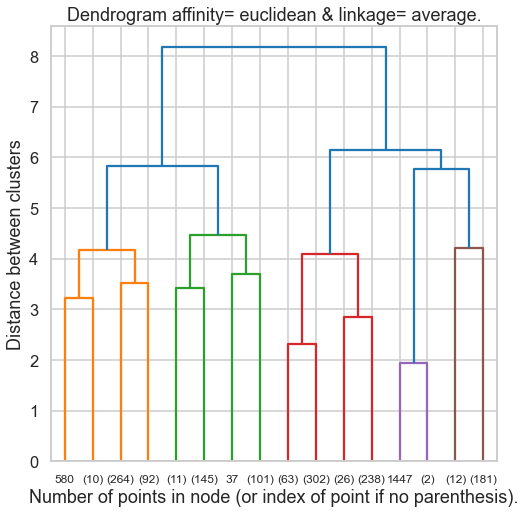

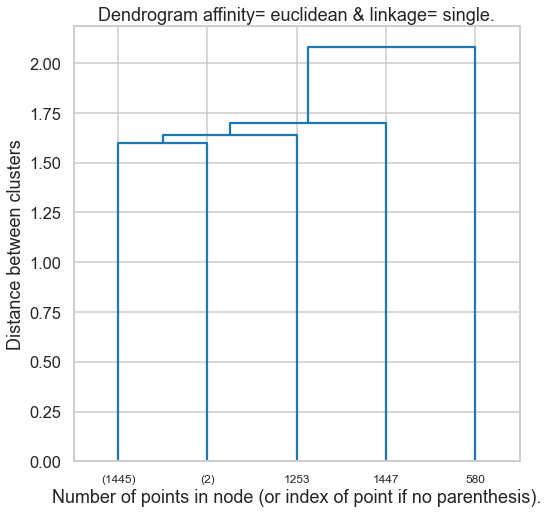

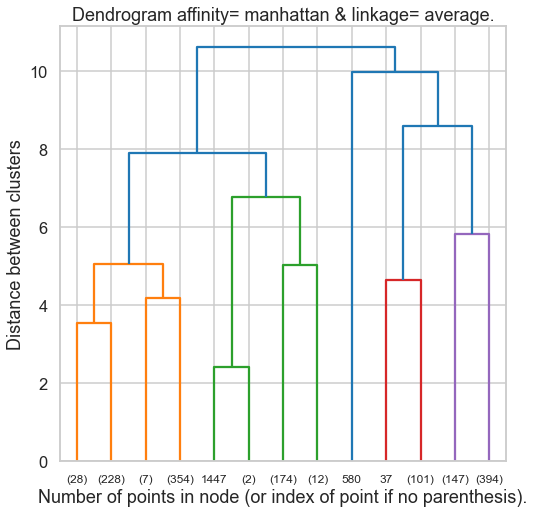

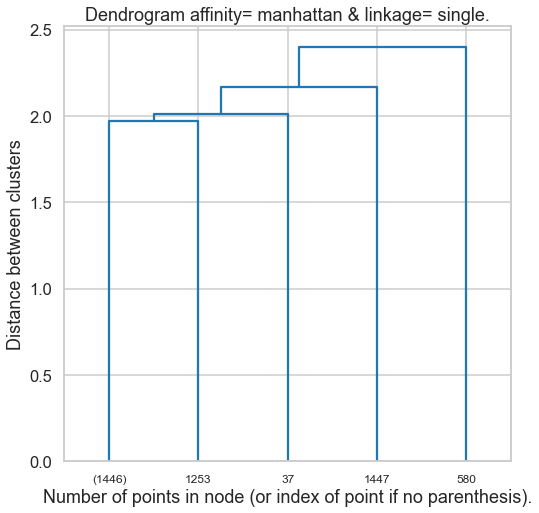

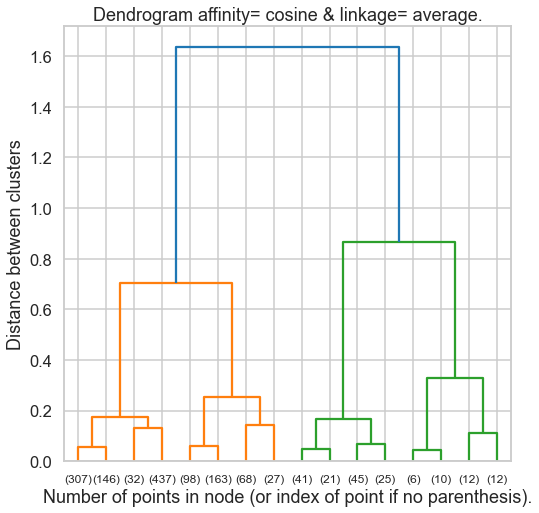

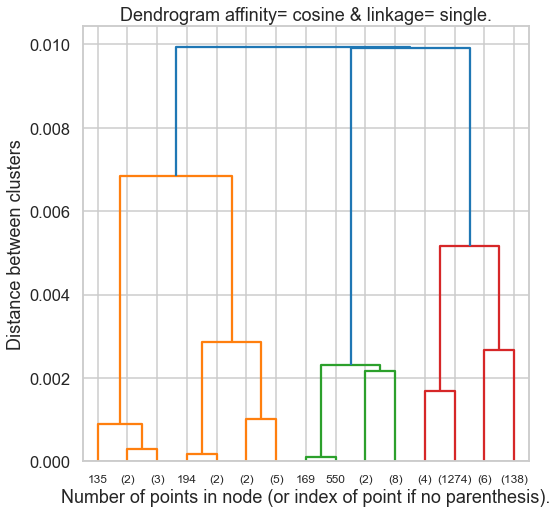

In [19]:
dendrogram_all(Multi_blob_Data)

Silhouette Score for euclidean and average is 0.41478815574933364


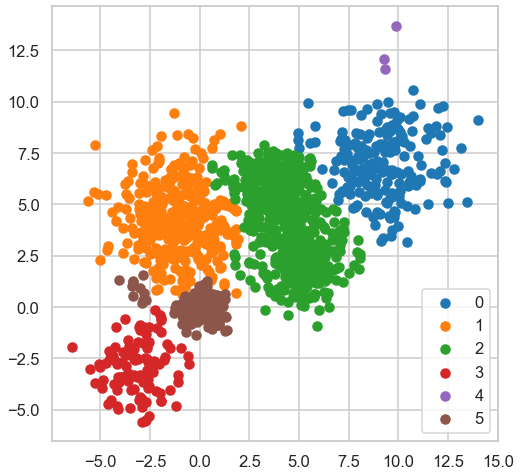

Silhouette Score for euclidean and single is 0.08705564851389591


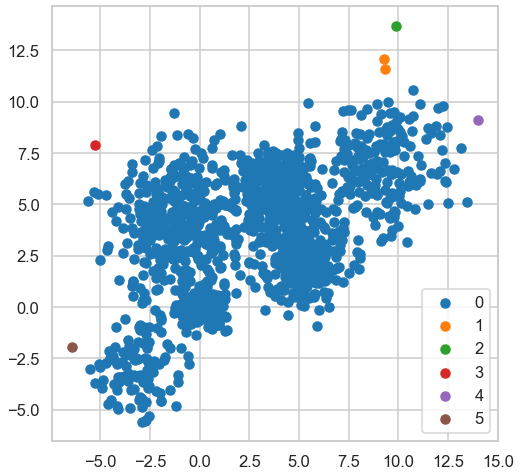

Silhouette Score for manhattan and average is 0.38029768112070367


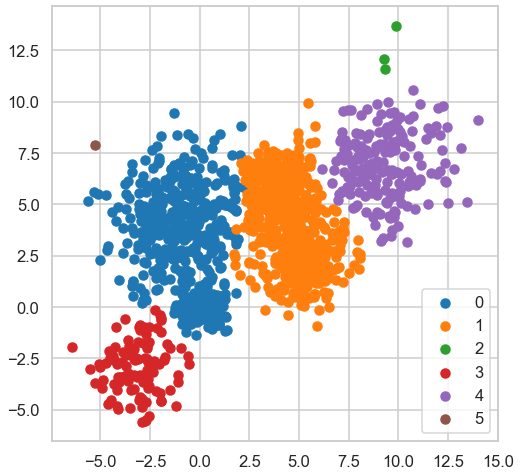

Silhouette Score for manhattan and single is 0.08705564851389591


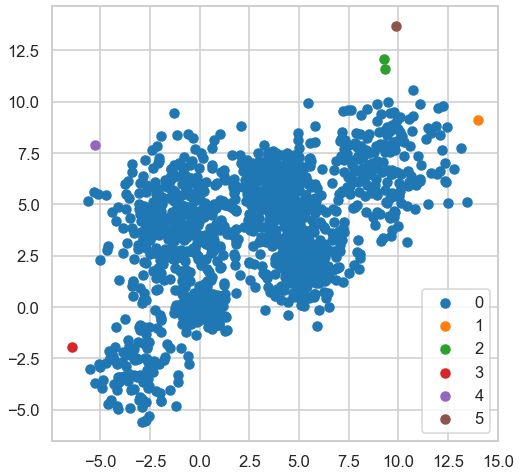

Silhouette Score for cosine and average is 0.2035575393889621


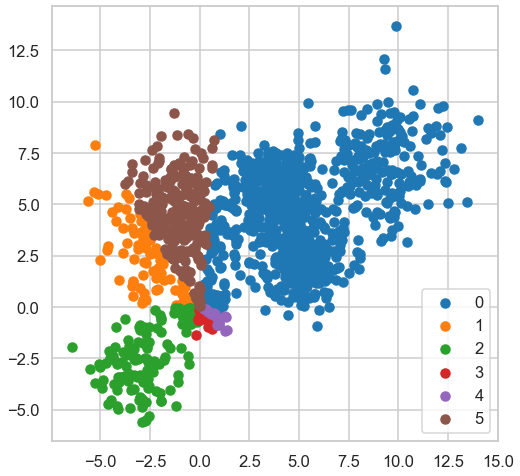

Silhouette Score for cosine and single is 0.07162243486315635


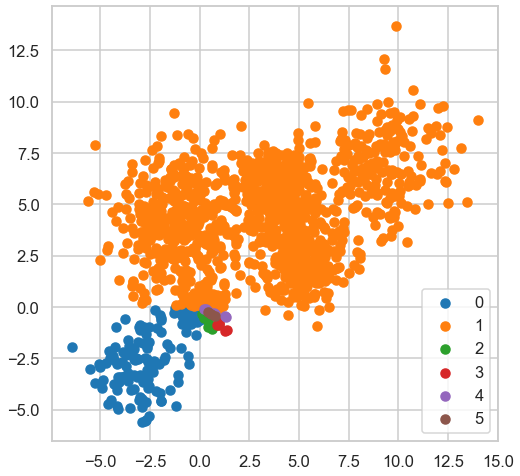

In [20]:
show_cluster_agg_2d(Multi_blob_Data,6)

In [21]:
#Best silhouette score --> euclidean average

In [22]:
s=[]
d=[]
for distance in np.arange(0.1,20,0.1):
    model = AgglomerativeClustering(distance_threshold=distance,n_clusters=None, affinity='euclidean', linkage='average')
    model = model.fit(Multi_blob_Data)
    if(len(np.unique(model.labels_))>1):
        silhouette=silhouette_score(Multi_blob_Data,model.labels_,metric='euclidean')
        s.append(silhouette)
        d.append(distance)
best_d_index=s.index(max(s))   
best_d=d[best_d_index]
print("Best distance_threshold is "+str(best_d)+" with a silhouette score of "+str(s[best_d_index])+".")

Best distance_threshold is 6.2 with a silhouette score of 0.4716908069861964.


In [23]:
#1
#distance_threshold=6.2 -->1
model = AgglomerativeClustering(distance_threshold=6.2,n_clusters=None, affinity='euclidean', linkage='average')
model = model.fit(Multi_blob_Data)
silhouette=silhouette_score(Multi_blob_Data,model.labels_,metric='euclidean')
silhouette

0.4716908069861964

In [24]:
#2
#n_clusters=6
model = AgglomerativeClustering(distance_threshold=None,n_clusters=6, affinity='euclidean', linkage='average')
model = model.fit(Multi_blob_Data)
silhouette=silhouette_score(Multi_blob_Data,model.labels_,metric='euclidean')
silhouette

0.41478815574933364

In [25]:
# 1 produces better results

### DBScan
* Use DBScan function to  to cluster the above data 
* In the  DBscan change the following parameters 
    * EPS (from 0.1 to 3)
    * Min_samples (from 5 to 25)
* Plot the silhouette_score versus the variation in the EPS and the min_samples
* Plot the resulting Clusters in this case 
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observations and comments 

Maximum silhouette score is0.4531919763890837at eps= 1.2000000000000002


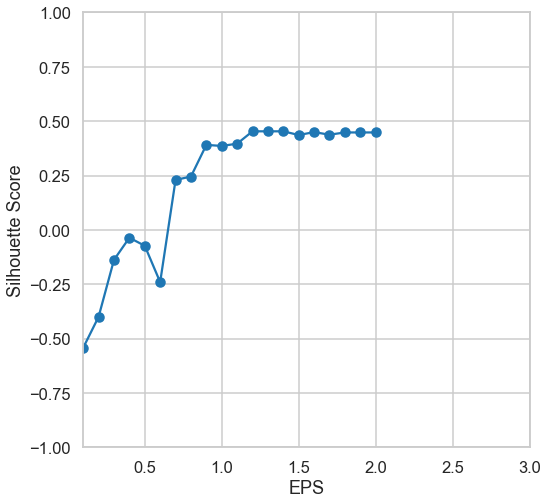

In [26]:
silhouette_scores_1= []
eps_1=[]
for eps_db in np.arange(0.1,3,0.1):
        clusters = DBSCAN(eps=eps_db).fit(Multi_blob_Data)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_1.append(silhouette_score(Multi_blob_Data,clusters.labels_,metric='euclidean'))
            eps_1.append(eps_db)
plt.xlim(0.1, 3)
plt.ylim(-1, 1)
plt.plot(eps_1,silhouette_scores_1)
plt.scatter(eps_1,silhouette_scores_1)
plt.xlabel('EPS')
plt.ylabel('Silhouette Score');
best_eps=eps_1[silhouette_scores_1.index(max(silhouette_scores_1))]
print("Maximum silhouette score is"+str(max(silhouette_scores_1))+ "at eps= "+str(best_eps))

Maximum silhouette score is at min_samples= 10


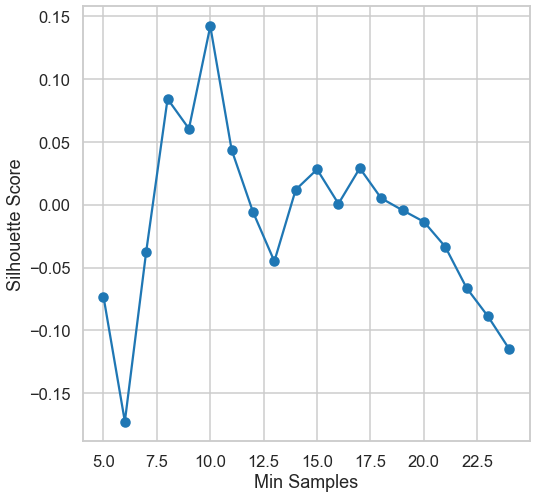

In [27]:
silhouette_scores_2= []
min_samples_1=[]
for min_samples_db in range(5,25,1):
        clusters = DBSCAN(min_samples=min_samples_db).fit(Multi_blob_Data)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_2.append(silhouette_score(Multi_blob_Data,clusters.labels_,metric='euclidean'))
            min_samples_1.append(min_samples_db)
plt.plot(min_samples_1,silhouette_scores_2)
plt.scatter(min_samples_1,silhouette_scores_2)
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score');
best_min_samples=min_samples_1[silhouette_scores_2.index(max(silhouette_scores_2))]
print("Maximum silhouette score is at min_samples= "+str(best_min_samples))

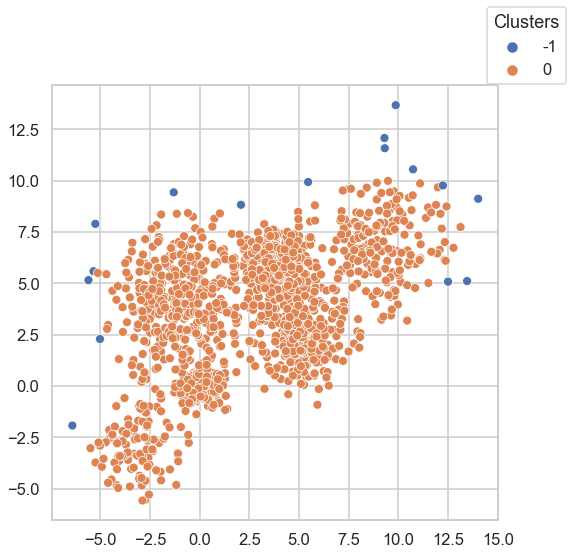

0.3909975437292683

In [28]:
clusters = DBSCAN(eps=1.2, min_samples=10).fit(Multi_blob_Data)
p = sns.scatterplot(data=Multi_blob_Data, x=Multi_blob_Data[:,0], y=Multi_blob_Data[:,1], hue=clusters.labels_, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()
score = silhouette_score(Multi_blob_Data, clusters.labels_)
score

### Gaussian Mixture
* Use GaussianMixture function to cluster the above data 
* In GMM change the covariance_type and check the difference in the resulting proabability fit 
* Use a 2D contour plot to plot the resulting distribution (the components of the GMM) as well as the total Gaussian mixture 

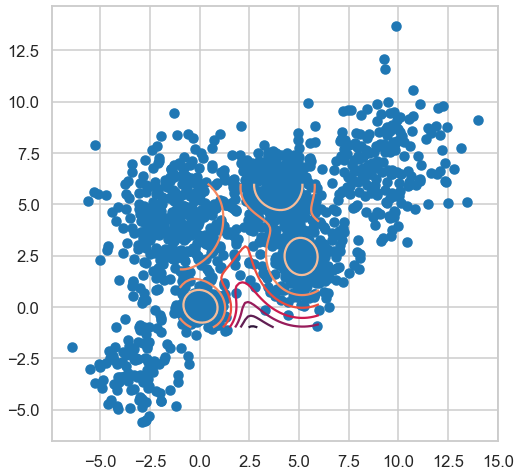

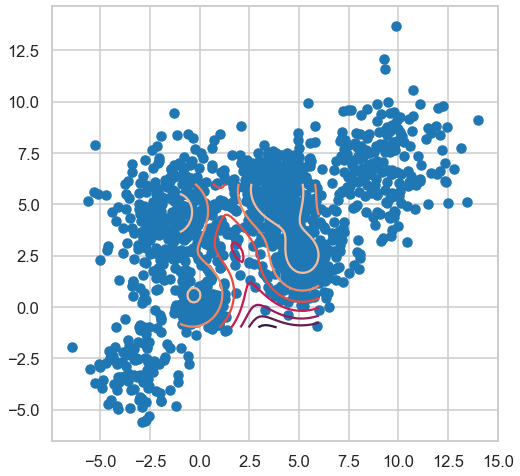

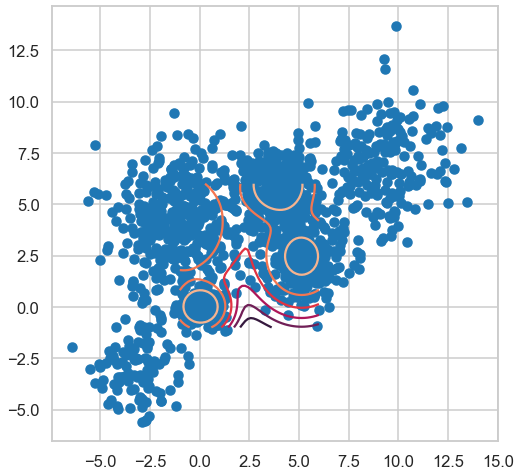

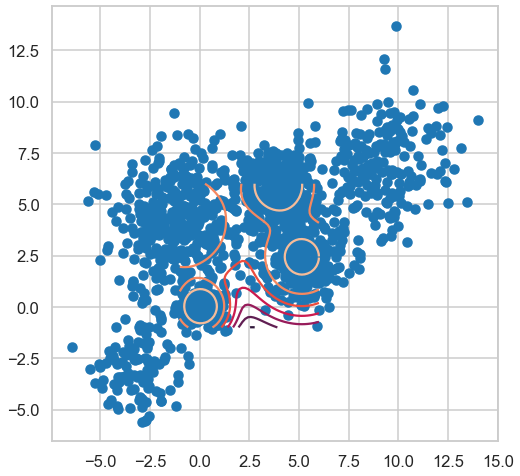

[0.4528776041763331, 0.485876089061064, 0.4549811746904482, 0.45377796134530934]


In [29]:
cov=["full","tied","diag","spherical"]
silhouette_gmm=[]
for cov1 in cov:
    gmm = GaussianMixture(n_components = 6, covariance_type=cov1)
    c=gmm.fit_predict(Multi_blob_Data)
    silhouette_gmm.append(silhouette_score(Multi_blob_Data,c, metric='euclidean'))
    plot_contour()
print(silhouette_gmm)    

In [30]:
#best covariance_type --> tied

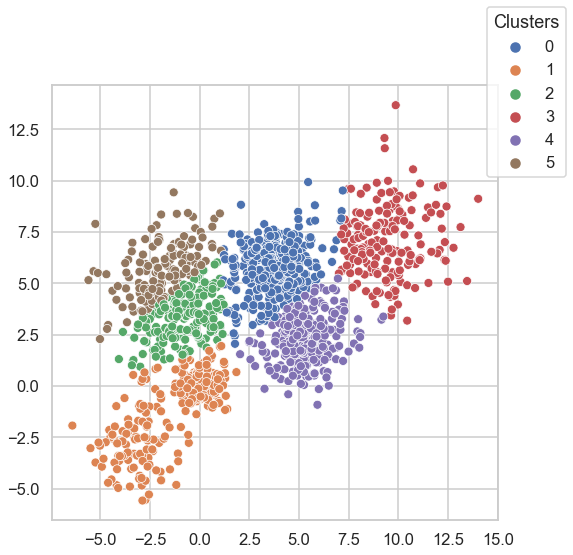

0.4190450059988444

In [31]:
gmm = GaussianMixture(n_components = 6, covariance_type='tied')
c=gmm.fit_predict(Multi_blob_Data)
p = sns.scatterplot(data=Multi_blob_Data, x=Multi_blob_Data[:,0], y=Multi_blob_Data[:,1], hue=c, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()
score = silhouette_score(Multi_blob_Data, c)
score

In [32]:
# K-Means produces best results for Multiblob 

## iris data set 
The iris data set is test data set that is part of the Sklearn module 
which contains 150 records each with 4 features. All the features are represented by real numbers 

The data represents three classes 


In [33]:
from sklearn.datasets import load_iris
iris_data = load_iris()
iris_data.target[[10, 25, 50]]
#array([0, 0, 1])
list(iris_data.target_names)
['setosa', 'versicolor', 'virginica']


['setosa', 'versicolor', 'virginica']

In [34]:
iris = pd.DataFrame(
    data= np.c_[iris_data['data'], iris_data['target']],
    columns= iris_data['feature_names'] + ['target']
    )
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [35]:
iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


# K-Means

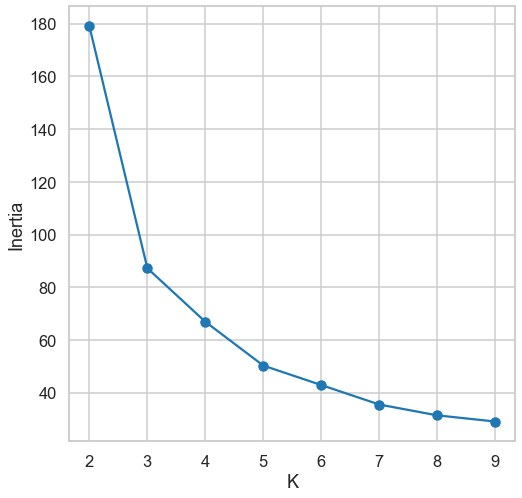

In [36]:
#Elbow Method
elbow(iris,2,10)

The best silhouette score is 0.6800825549093846 for 2 clusters.


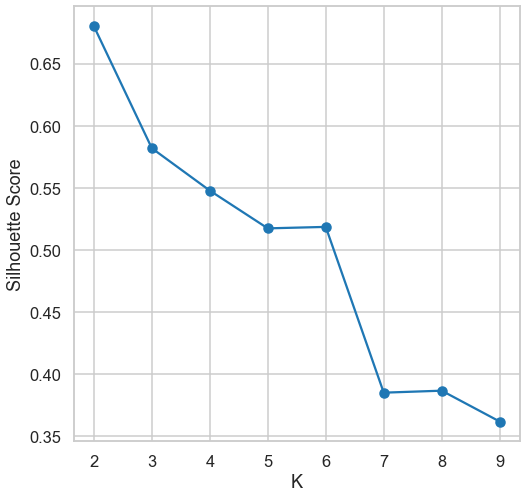

In [37]:
silhouette_vs_k(iris,2,10)

# Hierarchical Clustering

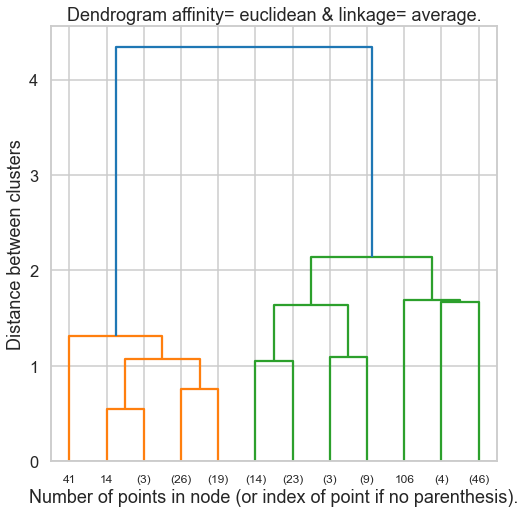

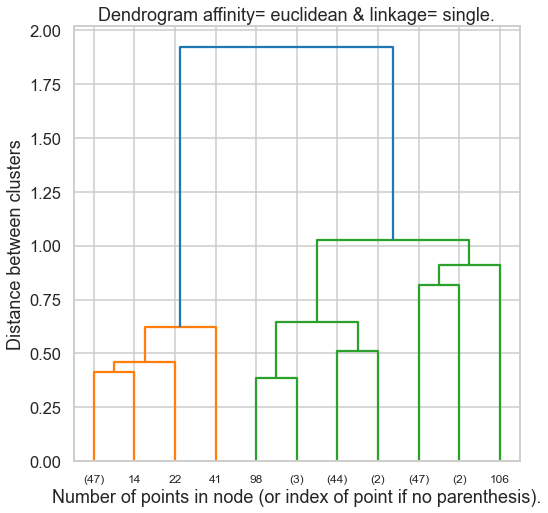

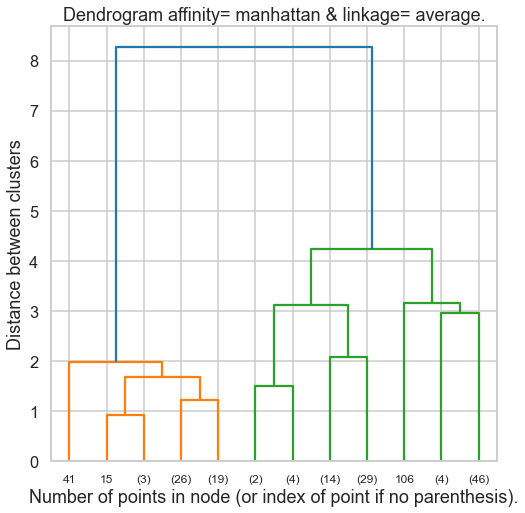

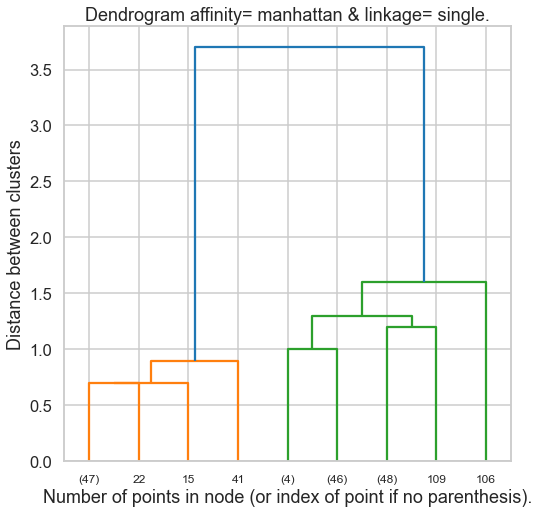

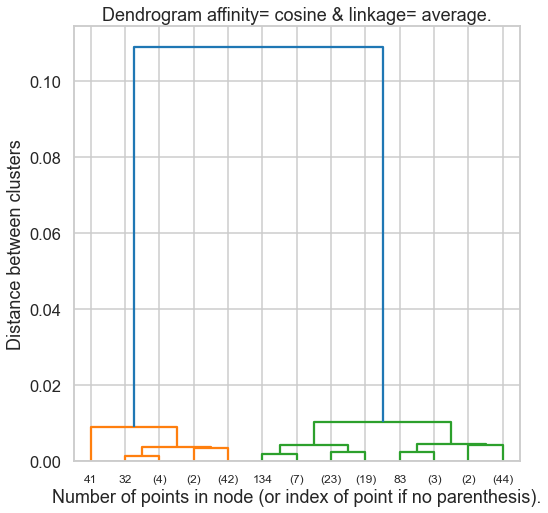

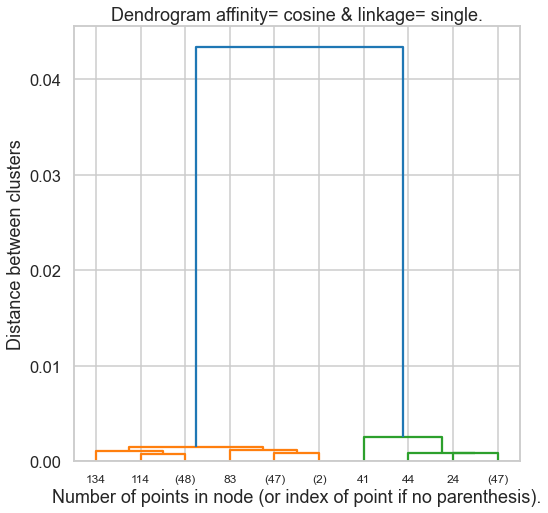

In [38]:
dendrogram_all(iris)

In [39]:
s=[]
for affinity in affinity_list:
       for linkage in linkage_list:
            model = AgglomerativeClustering(n_clusters=2, affinity=affinity, linkage=linkage)
            model = model.fit(iris)
            silhouette=silhouette_score(iris,model.labels_,metric='euclidean')
            s.append(silhouette)
            print("Silhouette Score for "+str(affinity)+" and "+str(linkage)+" is "+str(silhouette)+".")

Silhouette Score for euclidean and average is 0.6825350504469878.
Silhouette Score for euclidean and single is 0.6825350504469878.
Silhouette Score for manhattan and average is 0.6825350504469878.
Silhouette Score for manhattan and single is 0.6825350504469878.
Silhouette Score for cosine and average is 0.6825350504469878.
Silhouette Score for cosine and single is 0.6825350504469878.


In [40]:
s=[]
d=[]
for distance in np.arange(0.1,20,0.1):
    model = AgglomerativeClustering(distance_threshold=distance,n_clusters=None, affinity='euclidean', linkage='average')
    model = model.fit(iris)
    if(len(np.unique(model.labels_))>1):
        silhouette=silhouette_score(iris,model.labels_,metric='euclidean')
        s.append(silhouette)
        d.append(distance)
best_d_index=s.index(max(s))   
best_d=d[best_d_index]
print("Best distance_threshold is "+str(best_d)+" with a silhouette score of "+str(s[best_d_index])+".")

Best distance_threshold is 2.2 with a silhouette score of 0.6825350504469878.


In [41]:
#1
#distance_threshold=2.2 -->1
model = AgglomerativeClustering(distance_threshold=2.2,n_clusters=None, affinity='euclidean', linkage='average')
model = model.fit(iris)
silhouette=silhouette_score(iris,model.labels_,metric='euclidean')
silhouette

0.6825350504469878

In [42]:
#2
#n_clusters=2
model = AgglomerativeClustering(distance_threshold=None,n_clusters=2, affinity='euclidean', linkage='average')
model = model.fit(iris)
silhouette=silhouette_score(iris,model.labels_,metric='euclidean')
silhouette

0.6825350504469878

In [43]:
# 1&2 produce similar results

# DBScan

Maximum silhouette score is at eps= 1.1


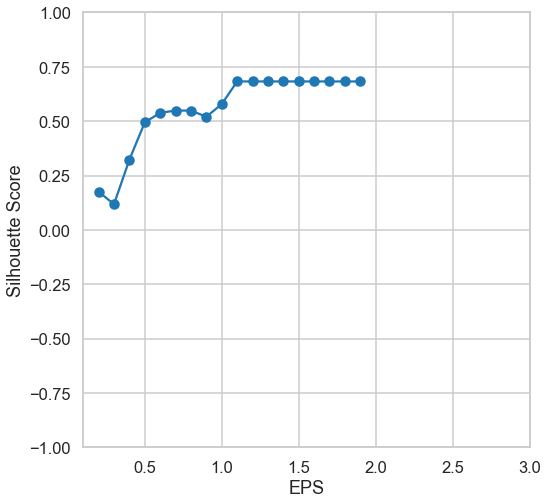

In [44]:
silhouette_scores_1= []
eps_1=[]
for eps_db in np.arange(0.1,3,0.1):
        clusters = DBSCAN(eps=eps_db).fit(iris)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_1.append(silhouette_score(iris,clusters.labels_,metric='euclidean'))
            eps_1.append(eps_db)
plt.xlim(0.1, 3)
plt.ylim(-1, 1)
plt.plot(eps_1,silhouette_scores_1)
plt.scatter(eps_1,silhouette_scores_1)
plt.xlabel('EPS')
plt.ylabel('Silhouette Score');
best_eps=eps_1[silhouette_scores_1.index(max(silhouette_scores_1))]
print("Maximum silhouette score is at eps= "+str(best_eps))

Maximum silhouette score is at min_samples= 17


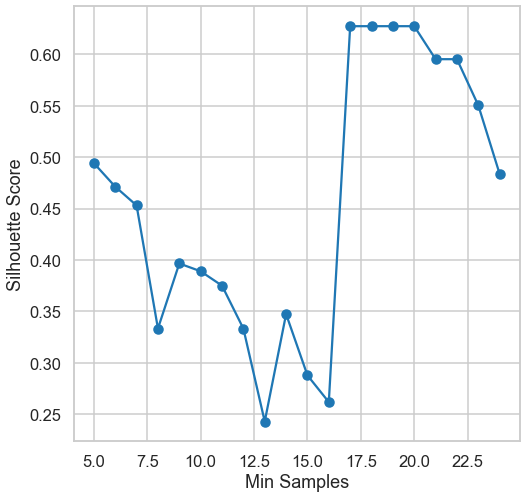

In [45]:
silhouette_scores_2= []
min_samples_1=[]
for min_samples_db in range(5,25,1):
        clusters = DBSCAN(min_samples=min_samples_db).fit(iris)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_2.append(silhouette_score(iris,clusters.labels_,metric='euclidean'))
            min_samples_1.append(min_samples_db)
plt.plot(min_samples_1,silhouette_scores_2)
plt.scatter(min_samples_1,silhouette_scores_2)
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score');
best_min_samples=min_samples_1[silhouette_scores_2.index(max(silhouette_scores_2))]
print("Maximum silhouette score is at min_samples= "+str(best_min_samples))

In [46]:
clusters = DBSCAN(eps=1.1, min_samples=17).fit(iris)
score = silhouette_score(iris, clusters.labels_)
score

0.6825350504469878

# GMM

In [47]:
cov=["full","tied","diag","spherical"]
silhouette_gmm=[]
for cov1 in cov:
    gmm = GaussianMixture(n_components = 2, covariance_type=cov1)
    c=gmm.fit_predict(iris)
    silhouette_gmm.append(silhouette_score(iris,c, metric='euclidean'))
    #plot_contour()silhouette_gmm.index(max(silhouette_gmm))
print(silhouette_gmm) 

[0.6825350504469878, 0.6825350504469878, 0.6825350504469878, 0.6825350504469878]


In [48]:
#best covariance_type --> all are the same in terms of silhouette score

In [49]:
gmm = GaussianMixture(n_components = 2, covariance_type='tied')
c=gmm.fit_predict(iris)
#p = sns.scatterplot(data=iris, x=iris[:,0], y=iris[:,1], hue=c, legend="full", palette="deep")
#sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
#plt.show()
score = silhouette_score(iris, c)
score

0.6825350504469878

In [50]:
# Hierarchical , DBScan and GMM produce best results in iris dataset

* Repeat all the above clustering approaches and steps on the above data 
* Normalize the data then repeat all the above steps 
* Compare between the different clustering approaches 

# Normalize & Repeat

In [51]:
#use standardscaler to normalize data
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(iris)
normalized=pd.DataFrame(normalized_data,columns = iris.columns)
normalized.head()
# produces alot of negative values

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.900681,1.019004,-1.340227,-1.315444,-1.224745
1,-1.143017,-0.131979,-1.340227,-1.315444,-1.224745
2,-1.385353,0.328414,-1.397064,-1.315444,-1.224745
3,-1.506521,0.098217,-1.283389,-1.315444,-1.224745
4,-1.021849,1.249201,-1.340227,-1.315444,-1.224745


In [52]:
#use MinMax scaler to put all data between 1 and 0
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(iris)
normalized=pd.DataFrame(normalized_data,columns = iris.columns)
normalized.head()
# produces alot of negative values

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,0.222222,0.625000,0.067797,0.041667,0.0
1,0.166667,0.416667,0.067797,0.041667,0.0
2,0.111111,0.500000,0.050847,0.041667,0.0
3,0.083333,0.458333,0.084746,0.041667,0.0
4,0.194444,0.666667,0.067797,0.041667,0.0


# K-Means (Normalized)

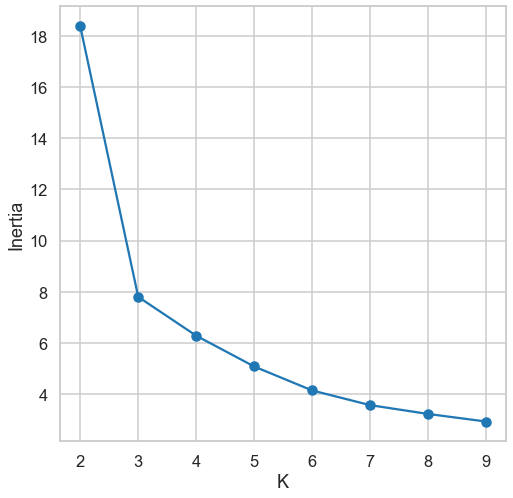

In [53]:
#Elbow Method
elbow(normalized,2,10)

The best silhouette score is 0.64025871206386 for 2 clusters.


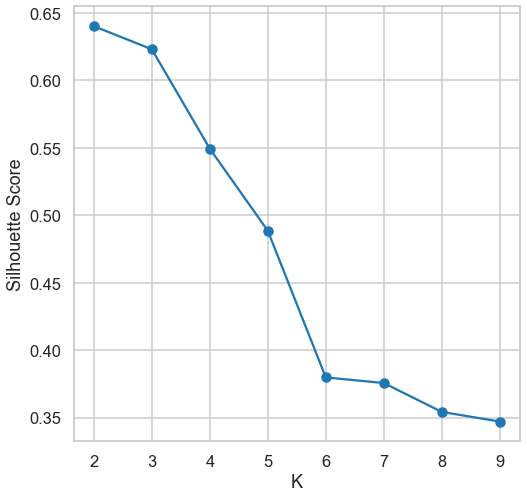

In [54]:
 silhouette_vs_k(normalized,2,10)#--> k-means above produced better result

# Hierarchical Clustering(Normalized)

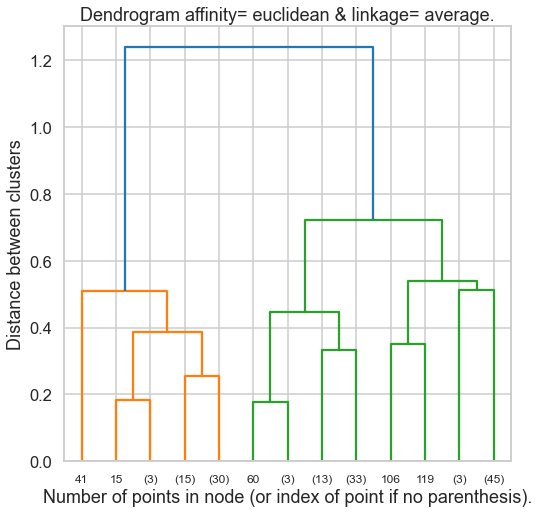

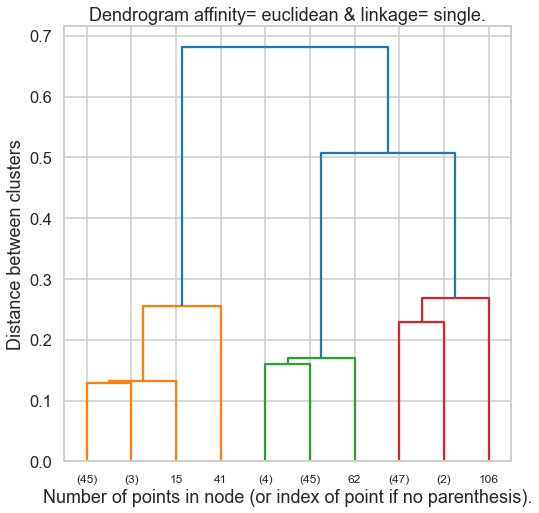

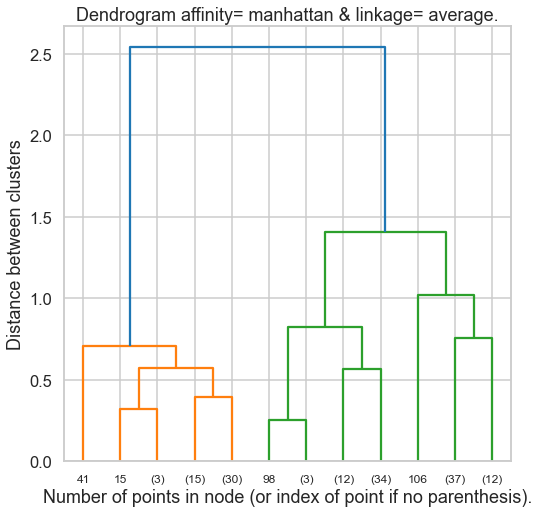

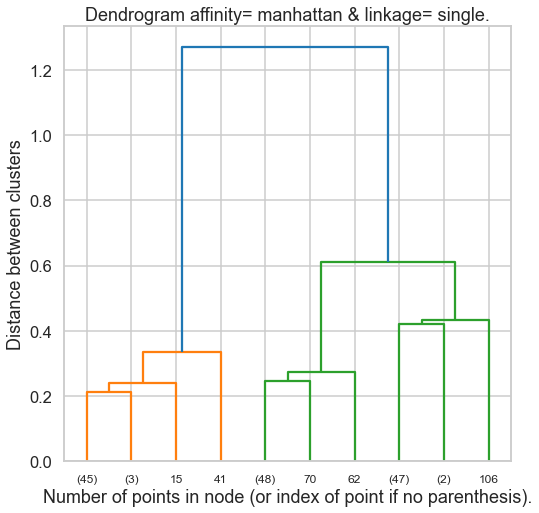

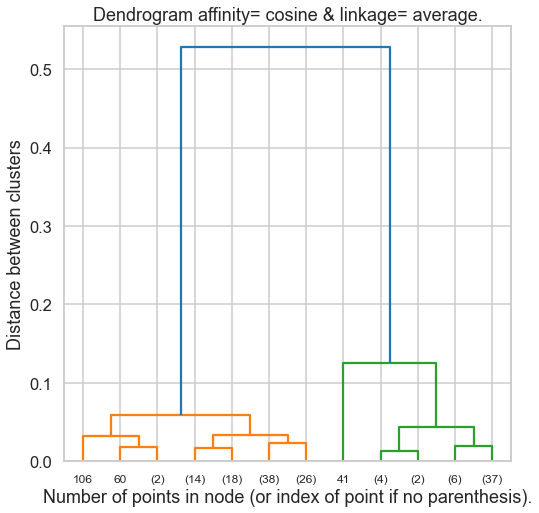

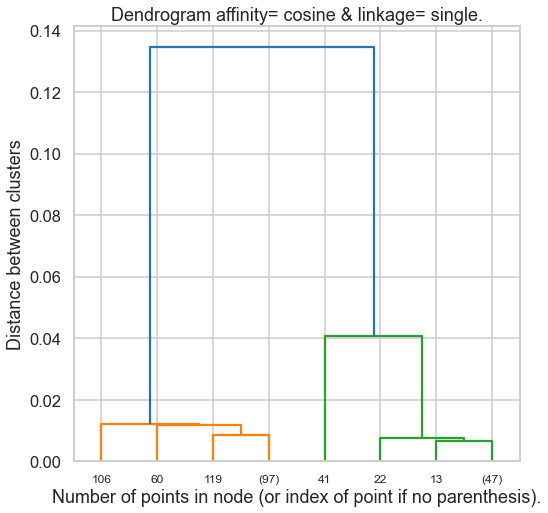

In [55]:
dendrogram_all(normalized)

In [56]:
s=[]
for affinity in affinity_list:
       for linkage in linkage_list:
            model = AgglomerativeClustering(n_clusters=2, affinity=affinity, linkage=linkage)
            model = model.fit(normalized)
            silhouette=silhouette_score(normalized,model.labels_,metric='euclidean')
            s.append(silhouette)
            print("Silhouette Score for "+str(affinity)+" and "+str(linkage)+" is "+str(silhouette)+".")
            #changing linkage and affinity has no effect

Silhouette Score for euclidean and average is 0.64025871206386.
Silhouette Score for euclidean and single is 0.64025871206386.
Silhouette Score for manhattan and average is 0.64025871206386.
Silhouette Score for manhattan and single is 0.64025871206386.
Silhouette Score for cosine and average is 0.64025871206386.
Silhouette Score for cosine and single is 0.64025871206386.


In [57]:
s=[]
d=[]
for distance in np.arange(0.1,20,0.1):
    model = AgglomerativeClustering(distance_threshold=distance,n_clusters=None, affinity='euclidean', linkage='average')
    model = model.fit(normalized)
    if(len(np.unique(model.labels_))>1):
        silhouette=silhouette_score(normalized,model.labels_,metric='euclidean')
        s.append(silhouette)
        d.append(distance)
best_d_index=s.index(max(s))   
best_d=d[best_d_index]
print("Best distance_threshold is "+str(best_d)+" with a silhouette score of "+str(s[best_d_index])+".")

Best distance_threshold is 0.8 with a silhouette score of 0.64025871206386.


In [58]:
#1
#distance_threshold=2.2 -->1
model = AgglomerativeClustering(distance_threshold=2.2,n_clusters=None, affinity='euclidean', linkage='average')
model = model.fit(normalized)
if(len(np.unique(model.labels_))>1):
    silhouette=silhouette_score(normalized,model.labels_,metric='euclidean')
    print(silhouette)
else:
    print("This combination of parameters is invalid")

This combination of parameters is invalid


In [59]:
#2
#n_clusters=2
model = AgglomerativeClustering(distance_threshold=None,n_clusters=2, affinity='euclidean', linkage='average')
model = model.fit(normalized)
silhouette=silhouette_score(normalized,model.labels_,metric='euclidean')
silhouette

0.64025871206386

# DBScan (Normalized)

Maximum silhouette score is at eps= 0.6


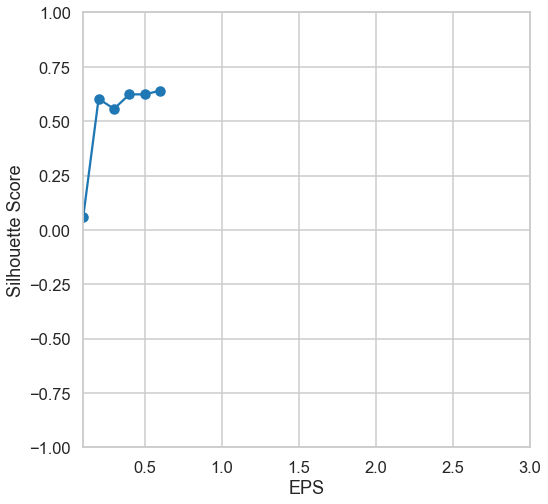

In [60]:
silhouette_scores_1= []
eps_1=[]
for eps_db in np.arange(0.1,3,0.1):
        clusters = DBSCAN(eps=eps_db).fit(normalized)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_1.append(silhouette_score(normalized,clusters.labels_,metric='euclidean'))
            eps_1.append(eps_db)
plt.xlim(0.1, 3)
plt.ylim(-1, 1)
plt.plot(eps_1,silhouette_scores_1)
plt.scatter(eps_1,silhouette_scores_1)
plt.xlabel('EPS')
plt.ylabel('Silhouette Score');
best_eps=eps_1[silhouette_scores_1.index(max(silhouette_scores_1))]
print("Maximum silhouette score is at eps= "+str(best_eps))

Maximum silhouette score is at min_samples= 5


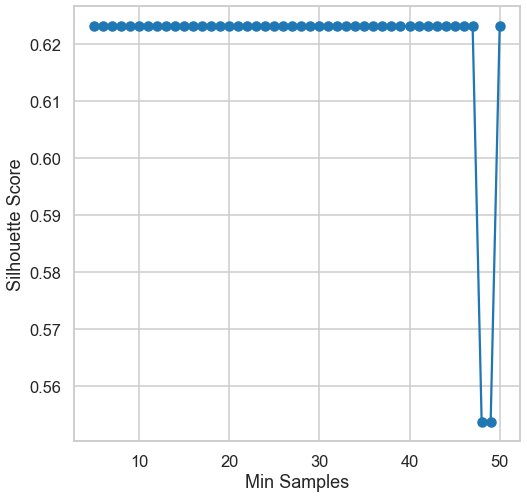

In [61]:
silhouette_scores_2= []
min_samples_1=[]
for min_samples_db in range(5,100,1):
        clusters = DBSCAN(min_samples=min_samples_db).fit(normalized)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_2.append(silhouette_score(normalized,clusters.labels_,metric='euclidean'))
            min_samples_1.append(min_samples_db)
plt.plot(min_samples_1,silhouette_scores_2)
plt.scatter(min_samples_1,silhouette_scores_2)
plt.xlabel('Min Samples')
plt.ylabel('Silhouette Score');
best_min_samples=min_samples_1[silhouette_scores_2.index(max(silhouette_scores_2))]
print("Maximum silhouette score is at min_samples= "+str(best_min_samples))

In [62]:
clusters = DBSCAN(eps=0.6, min_samples=5).fit(normalized)
score = silhouette_score(iris, clusters.labels_)
score

0.6825350504469878

# GMM (Normalized)

In [63]:
cov=["full","tied","diag","spherical"]
silhouette_gmm=[]
for cov1 in cov:
    gmm = GaussianMixture(n_components = 2, covariance_type=cov1)
    c=gmm.fit_predict(normalized)
    silhouette_gmm.append(silhouette_score(normalized,c, metric='euclidean'))
    #plot_contour()silhouette_gmm.index(max(silhouette_gmm))
print(silhouette_gmm) 

[0.64025871206386, 0.64025871206386, 0.64025871206386, 0.64025871206386]


In [64]:
#best covariance_type --> all are the same in terms of silhouette score
gmm = GaussianMixture(n_components = 2, covariance_type='tied')
c=gmm.fit_predict(normalized)
#p = sns.scatterplot(data=iris, x=iris[:,0], y=iris[:,1], hue=c, legend="full", palette="deep")
#sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
#plt.show()
score = silhouette_score(normalized, c)
score

0.64025871206386

In [65]:
#DBScan produces best result while all other techniques produce the 
#same silhouette score which is not very far from the DBScan

## Customer dataset
Repeat all the above on the customer data set 

In [66]:
df=pd.read_csv('Customer data.csv')

In [67]:
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [68]:
df.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


# K Means

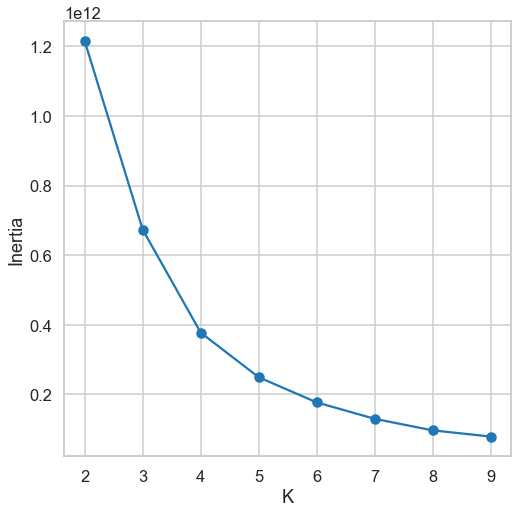

In [69]:
#Elbow Method
elbow(df,2,10)

The best silhouette score is 0.5828454744042287 for 2 clusters.


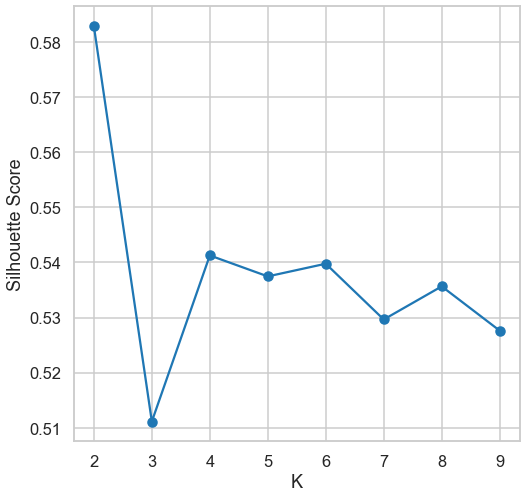

In [70]:
silhouette_vs_k(df,2,10)

In [71]:
km = KMeans(n_clusters=2)
c= km.fit_predict(df)

# Hierarchical

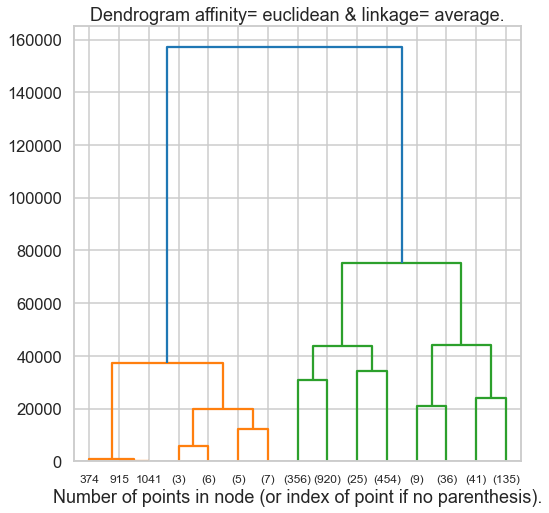

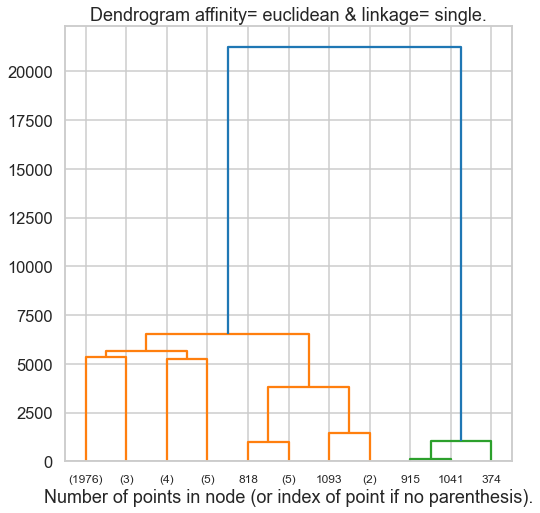

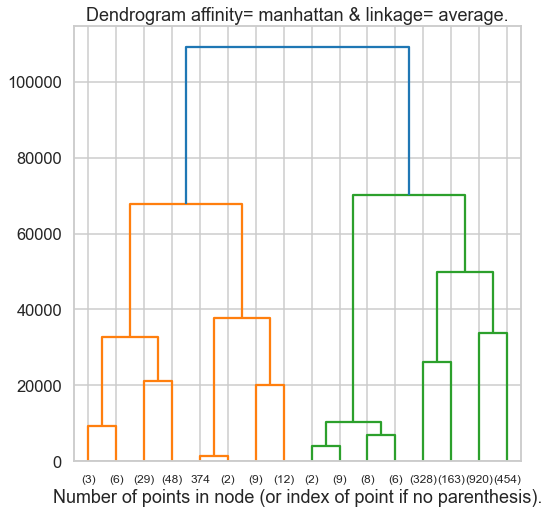

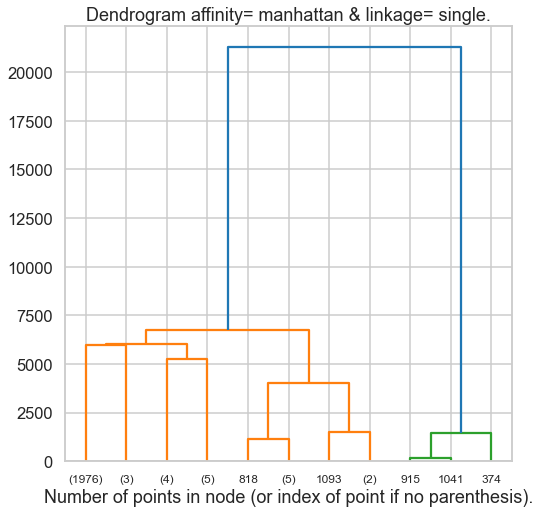

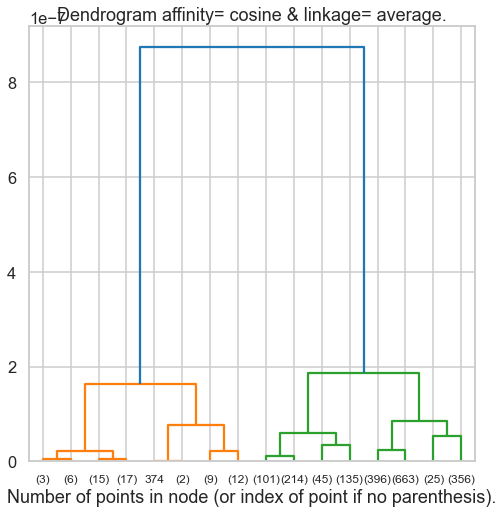

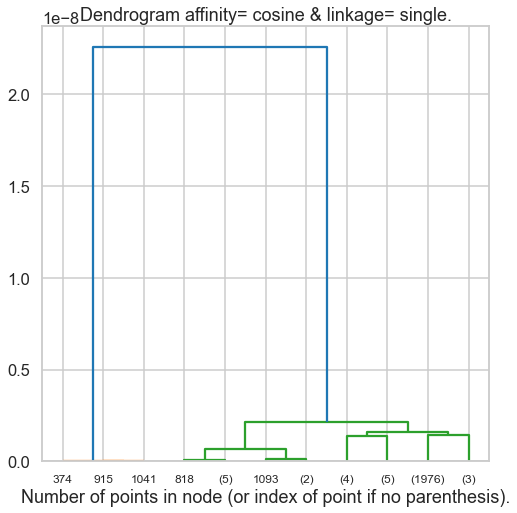

In [72]:
linkage_list=["average","single"]
affinity_list=["euclidean","manhattan","cosine"]
for affinity in affinity_list:
       for linkage in linkage_list:
            model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity=affinity, linkage=linkage)
            model = model.fit(df)
            plt.title('Dendrogram affinity= '+str(affinity)+" & linkage= "+str(linkage)+".")
            plot_dendrogram(model, truncate_mode='level', p=3)
            plt.xlabel("Number of points in node (or index of point if no parenthesis).")
            plt.show()

In [73]:
s=[]
for affinity in affinity_list:
       for linkage in linkage_list:
            model = AgglomerativeClustering(n_clusters=2, affinity=affinity, linkage=linkage)
            model = model.fit(df)
            silhouette=silhouette_score(df,model.labels_,metric='euclidean')
            s.append(silhouette)
            print("Silhouette Score for "+str(affinity)+" and "+str(linkage)+" is "+str(silhouette)+".")

Silhouette Score for euclidean and average is 0.7291325936434838.
Silhouette Score for euclidean and single is 0.7584225808642502.
Silhouette Score for manhattan and average is 0.6591926879182072.
Silhouette Score for manhattan and single is 0.7584225808642502.
Silhouette Score for cosine and average is 0.6855565864359844.
Silhouette Score for cosine and single is 0.7584225808642502.


In [74]:
# best --> euclidean single, manhattan single and cosine single

In [75]:
s=[]
d=[]
for distance in np.arange(10,50000,100):
    model = AgglomerativeClustering(distance_threshold=distance,n_clusters=None, affinity='euclidean', linkage='average')
    model = model.fit(df)
    if(len(np.unique(model.labels_))>1):
        silhouette=silhouette_score(df,model.labels_,metric='euclidean')
        s.append(silhouette)
        d.append(distance)
best_d_index=s.index(max(s))   
best_d=d[best_d_index]
print("Best distance_threshold is "+str(best_d)+" with a silhouette score of "+str(s[best_d_index])+".")

Best distance_threshold is 44110 with a silhouette score of 0.5712976294538014.


In [76]:
#using n_clusters produces better results (euclidean single, manhattan single and cosine single)

# DBScan

In [77]:
#clusters = DBSCAN(eps=eps_db).fit(df)
#len(np.unique(clusters.labels_))

In [78]:
silhouette_scores_1= []
eps_1=[]
for eps_db in np.arange(0.1,10,0.1):
        clusters = DBSCAN(eps=eps_db).fit(df)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_1.append(silhouette_score(df,clusters.labels_,metric='euclidean'))
            eps_1.append(eps_db)
#plt.xlim(0.1, 3)
#plt.ylim(-1, 1)
#plt.plot(eps_1,silhouette_scores_1)
#plt.scatter(eps_1,silhouette_scores_1)
#plt.xlabel('EPS')
#plt.ylabel('Silhouette Score');

if(len(silhouette_scores_1)>0):
    best_eps=eps_1[silhouette_scores_1.index(max(silhouette_scores_1))]
    print("Maximum silhouette score is at eps= "+str(best_eps))
    plt.xlim(0.1, 3)
    plt.ylim(-1, 1)
    plt.plot(eps_1,silhouette_scores_1)
    plt.scatter(eps_1,silhouette_scores_1)
    plt.xlabel('EPS')
    plt.ylabel('Silhouette Score');
else:
    print("Points are very near to each other and cannot be clustered using DBScan")

Points are very near to each other and cannot be clustered using DBScan


Maximum silhouette score is at eps= 7.4


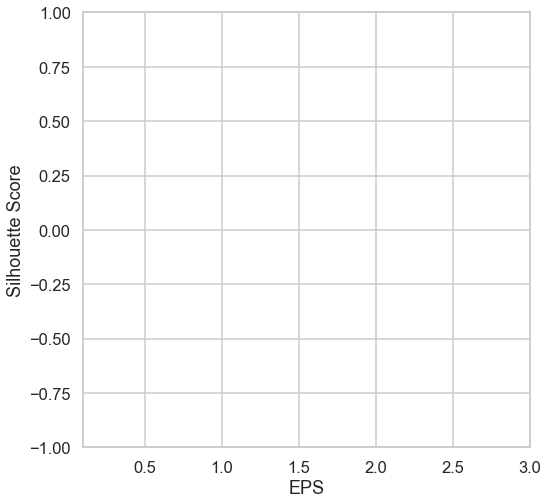

In [79]:
silhouette_scores_1= []
eps_1=[]
for eps_db in np.arange(0.1,10,0.1):
        clusters = DBSCAN(eps=eps_db,min_samples=2).fit(df)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_1.append(silhouette_score(df,clusters.labels_,metric='euclidean'))
            eps_1.append(eps_db)
#plt.xlim(0.1, 3)
#plt.ylim(-1, 1)
#plt.plot(eps_1,silhouette_scores_1)
#plt.scatter(eps_1,silhouette_scores_1)
#plt.xlabel('EPS')
#plt.ylabel('Silhouette Score');

if(len(silhouette_scores_1)>0):
    best_eps=eps_1[silhouette_scores_1.index(max(silhouette_scores_1))]
    print("Maximum silhouette score is at eps= "+str(best_eps))
    plt.xlim(0.1, 3)
    plt.ylim(-1, 1)
    plt.plot(eps_1,silhouette_scores_1)
    plt.scatter(eps_1,silhouette_scores_1)
    plt.xlabel('EPS')
    plt.ylabel('Silhouette Score');
else:
    print("Points are very near to each other and cannot be clustered using DBScan")

In [80]:
#
silhouette_scores_1 # data cannot be clustered using dbscan as normally all points are considered as one cluster and even
#when min_samples is chosen to be a small value the silhouette scores recorded show that clusters are overlapping

[-0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626,
 -0.4097946063656626]

In [81]:
silhouette_scores_2= []
min_samples_1=[]
for min_samples_db in range(5,25,1):
        clusters = DBSCAN(min_samples=min_samples_db).fit(df)
        if(len(np.unique(clusters.labels_))>1):
            silhouette_scores_2.append(silhouette_score(df,clusters.labels_,metric='euclidean'))
            min_samples_1.append(min_samples_db)

if(len(silhouette_scores_2)>0):
    best_min_samples=min_samples_1[silhouette_scores_2.index(max(silhouette_scores_2))]
    print("Maximum silhouette score is at min_samples= "+str(best_min_samples))
    plt.plot(min_samples_1,silhouette_scores_2)
    plt.scatter(min_samples_1,silhouette_scores_2)
    plt.xlabel('Min Samples')
    plt.ylabel('Silhouette Score');
else:
    print("Points are very near to each other and cannot be clustered using DBScan")

Points are very near to each other and cannot be clustered using DBScan


# GMM

In [82]:
cov=["full","tied","diag","spherical"]
silhouette_gmm=[]
for cov1 in cov:
    gmm = GaussianMixture(n_components = 2, covariance_type=cov1)
    c=gmm.fit_predict(df)
    silhouette_gmm.append(silhouette_score(df,c, metric='euclidean'))
    #plot_contour()silhouette_gmm.index(max(silhouette_gmm))
print(silhouette_gmm) 

[-0.013764834710828936, 0.6373718567082967, 0.19055534716550512, 0.565381887204057]


In [83]:
#best covariance_type --> tied

In [84]:
gmm = GaussianMixture(n_components = 2, covariance_type='tied')
c=gmm.fit_predict(df)
score = silhouette_score(df, c)
score

0.6373718567082967

In [85]:
#Hierarchical produces best result
# DBScan has the worst silhouette score (-ve values --> overlapping clusters)